### Numerical solutions

### 1. GARCH vol with trading costs

Solve:
$    V(v_{t-1})=\min_{v_t}\Bigg[\frac{1}{2}(v_t-v_{t-1})'\Lambda_t(v_t-v_{t-1})+(1-\rho)\bigg(\frac{1}{2}v_{t}'\mathbb{E}_{t}\big[\Omega_{t+1}]v_{t} +\mathbb{E}_t[V(v_{t})] \bigg)\Bigg] - \lambda_{t} (v_{t}'\textbf{1}-1)$

In [2]:
import quadprog
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import numpy as np
import pandas as pd
from numpy.linalg import multi_dot as mdot
from numpy import dot
from numpy import divide
from numpy.linalg import inv

In [3]:
# Setup
rho = 0.001
Omega_t_plus_1 = np.array([[3, .4, .6],
                           [.2, 4, .7],
                           [.1, .9, 5]])
gamma = 2

In [4]:
def v_t_analytical(Omega_t_plus_1):
    p = len(Omega_t_plus_1)
    ones = np.ones((p, 1))
    v_t_anal = divide(dot(inv(Omega_t_plus_1), ones), mdot([ones.T, inv(Omega_t_plus_1), ones]))
    return np.ravel(v_t_anal)

In [30]:
def Lambda(Omega, gamma):
    return dot(Omega, gamma)

In [26]:
def eq_constraint(v_t):
    return np.sum(v_t)-1

In [27]:
def V_t(v_t, v_t_1, Omega_t_plus_1, rho, gamma):
    first_term = 0.5*mdot([(v_t-v_t_1).T, Lambda(Omega_t_plus_1, gamma), (v_t-v_t_1)])
    second_term = (1-rho)*(0.5*(mdot([v_t.T, Omega_t_plus_1, v_t])))
    return (first_term + second_term)

In [28]:
def solve_V_t(Omega_t_plus_1):
    p = Omega_t_plus_1.shape[0]
    constraint = [{'type': 'eq', 'fun': eq_constraint}]
    res =minimize(fun = V_t, 
             x0 = np.full((p, 1), 1/p),
             args = (v_t_analytical(Omega_t_plus_1), Omega_t_plus_1, rho),
             constraints=constraint,
             method="SLSQP")
    v_t_num = res.x

## Testing how to solve for $A_{vv}$

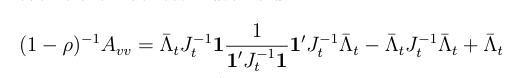

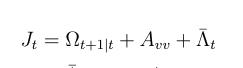

In [237]:
# Setup
rho = 0.001
Omega_t_plus_1 = np.array([[.2, .4, .6],
                           [.2, 4, .7],
                           [.1, .9, 5]])
Lambda_t = np.array([[0.03, 0.02, 0.16],
                           [.2, .2, 0.7],
                           [.1, 0.09, 0.5]])
Avv_guess = np.array([[0.02992854, 0.02003987, 0.15647208],
       [0.19801891, 0.1983378 , 0.68126664],
       [0.09885875, 0.08914228, 0.48635607]])

p = Omega_t_plus_1.shape[0]
gamma = 2
ones = np.ones((p, 1))

In [238]:
def J_t_inv(Avv):
    Avv = np.reshape(Avv, (p, p))
    return np.linalg.inv(Omega_t_plus_1 + Avv + Lambda_t)

In [239]:
def LHS(Avv):
    Avv = np.reshape(Avv, (p, p))
    return (1/(1-rho))*Avv

In [240]:
def RHS(Avv):
    Avv = np.reshape(Avv, (p, p))
    return mdot([Lambda_t, J_t_inv(Avv), ones, 1/(mdot([ones.T, J_t_inv(Avv), ones])), ones.T, J_t_inv(Avv), Lambda_t])-mdot([Lambda_t, J_t_inv(Avv), Lambda_t]) + Lambda_t

In [241]:
def compare_sides(Avv):
    Avv = np.reshape(Avv, (p, p))
    Left = LHS(Avv)
    Right = RHS(Avv)
    diff = np.abs(Left-Right)
    return np.sum(diff)

In [242]:
def check_symmetric(Avv, rtol=1e-05, atol=1e-08):
    Avv = np.reshape(Avv, (p, p))
    diff = np.abs(Avv-Avv.T)
    return np.sum(diff)

In [295]:
def solve_Avv():
    constraint = [{'type': 'eq', 'fun': check_symmetric}]
    options = {"maxiter": 2000}
    res =minimize(fun = compare_sides, 
             x0 = Avv_guess,
            constraints=constraint,
            method = 'SLSQP',
                  options = options,
                 tol = 1e-8)
    return res

In [296]:
res = solve_Avv()

In [297]:
res

     fun: 0.8295705384957806
     jac: array([-0.9930369 ,  0.99447197, -1.00243606, -0.99815899, -1.00328188,
       -1.00156215,  0.99019488,  1.00981088,  1.00299722])
 message: 'Optimization terminated successfully.'
    nfev: 4786
     nit: 269
    njev: 269
  status: 0
 success: True
       x: array([0.02848504, 0.16459002, 0.10984029, 0.16459002, 0.19736949,
       0.66823957, 0.10984029, 0.66823957, 0.48578228])

In [298]:
Avv_try = np.reshape(res.x, (p, p))

In [299]:
LHS(Avv_try)-RHS(Avv_try)

array([[-1.40733876e-03,  1.44724940e-01, -4.65528331e-02],
       [-3.31180153e-02, -6.09117926e-04, -1.20909548e-02],
       [ 1.11780518e-02,  5.79863513e-01,  2.57745870e-05]])

In [300]:
RHS(Avv_try)

array([[0.02992089, 0.02002983, 0.15650308],
       [0.19787279, 0.19817618, 0.68099944],
       [0.09877219, 0.08904497, 0.48624277]])

In [301]:
Avv_try

array([[0.02848504, 0.16459002, 0.10984029],
       [0.16459002, 0.19736949, 0.66823957],
       [0.10984029, 0.66823957, 0.48578228]])